# Introduction to Quantum Error Correction via the Repetition Code

## Introduction

Quantum computing requires us to encode information in qubits. Most quantum algorithms developed over the past few decades have assumed that these qubits are perfect: they can be prepared in any state we desire, and be manipulated with complete precision. Qubits that obey these assumptions are often known as *logical qubits*.

The last few decades have also seen great advances in finding physical systems that behave as qubits, with better quality qubits being developed all the time. However, the imperfections can never be removed entirely. These qubits will always be much too imprecise to serve directly as logical qubits. Instead, we refer to them as *physical qubits*.

In the current era of quantum computing, we seek to use physical qubits despite their imperfections, by designing custom algorithms and using error mitigation effects. For the future era of fault-tolerance, however, we must find ways to build logical qubits from physical qubits. This will be done through the process of quantum error correction, in which logical qubits are encoded in a large number of physical qubits. The encoding is maintained by constantly putting the physical qubits through a highly entangling circuit. Auxilliary degrees of freedom are also constantly measured, to detect signs of errors and allow their effects to be removed. The operations on the logical qubits required to implement quantum computation will be performed by essentially making small perturbations to this procedure.

Because of the vast amount of effort required for this process, most operations performed in fault-tolerant quantum computers will be done to serve the purpose of error detection and correction. So when benchmarking our progress towards fault-tolerant quantum computation, we must keep track of how well our devices perform error correction.

In this chapter we will look at a particular example of error correction: the repetition code. Though not a true example of quantum error correction - it uses physical qubits to encode a logical *bit*, rather than a qubit - it serves as a simple guide to all the basic concepts in any quantum error correcting code. We will also see how it can be run on current prototype devices.

## Introduction to the repetition code

### The basics of error correction

The basic ideas behind error correction are the same for quantum information as for classical information. This allows us to begin by considering a very straightforward example: speaking on the phone. If someone asks you a question to which the answer is 'yes' or 'no', the way you give your response will depend on two factors:

* How important is it that you are understood correctly?
* How good is your connection?

Both of these can be paramaterized with probabilities. For the first, we can use $P_a$, the maximum acceptable probability of being misunderstood. If you are being asked to confirm a preference for ice cream flavours, and don't mind too much if you get vanilla rather than chocolate, $P_a$ might be quite high. If you are being asked a question on which someone's life depends, however, $P_a$ will be much lower.

For the second we can use $p$, the probability that your answer is garbled by a bad connection. For simplicity, let's imagine a case where a garbled 'yes' doesn't simply sound like nonsense, but sounds like a 'no'. And similarly a 'no' is transformed into 'yes'. Then $p$ is the probability that you are completely misunderstood.

A good connection or a relatively unimportant question will result in $p<P_a$. In this case it is fine to simply answer in the most direct way possible: you just say 'yes' or 'no'.

If, however, your connection is poor and your answer is important, we will have $p>P_a$. A single 'yes' or 'no' is not enough in this case. The probability of being misunderstood would be too high. Instead we must encode our answer in a more complex structure, allowing the receiver to decode our meaning despite the possibility of the message being disrupted. The simplest method is the one that many would do without thinking: simply repeat the answer many times. For example say 'yes, yes, yes' instead of 'yes' or 'no, no no' instead of 'no'.

If the receiver hears 'yes, yes, yes' in this case, they will of course conclude that the sender meant 'yes'. If they hear 'no, yes, yes', 'yes, no, yes' or 'yes, yes, no', they will probably conclude the same thing, since there is more positivity than negativity in the answer. To be misunderstood in this case, at least two of the replies need to be garbled. The probability for this, $P$, will be less than $p$. When encoded in this way, the message therefore becomes more likely to be understood. The code cell below shows an example of this.

In [1]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('Probability of a single reply being garbled: {}'.format(p1))
print('Probability of a the majority of three replies being garbled: {:.4f}'.format(p3))

Probability of a single reply being garbled: 0.01
Probability of a the majority of three replies being garbled: 0.0003


If $P<P_a$, this technique solves our problem. If not, we can simply add more repetitions. The fact that $P<p$ above comes from the fact that we need at least two replies to be garbled to flip the majority, and so even the most likely possibilities have a probability of $\sim p^2$. For five repetitions we'd need at least three replies to be garbled to flip the majority, which happens with probability $\sim p^3$. The value for $P$ in this case would then be even lower. Indeed, as we increase the number of repetitions, $P$ will decrease exponentially. No matter how bad the connection, or how certain we need to be of our message getting through correctly, we can achieve it by just repeating our answer enough times.

Though this is a simple example, it contains all the aspects of error correction.
* There is some information to be sent or stored: In this case, a 'yes' or 'no.
* The information is encoded in a larger system to protect it against noise: In this case, by repeating the message.
* The information is finally decoded, mitigating for the effects of noise: In this case, by trusting the majority of the transmitted messages.

This same encoding scheme can also be used for binary, by simply substituting `0` and `1` for 'yes' and 'no. It can therefore also be easily generalized to qubits by using the states $\left|0\right\rangle$ and $\left|1\right\rangle$. In each case it is known as the *repetition code*. Many other forms of encoding are also possible in both the classical and quantum cases, which outperform the repetition code in many ways. However, its status as the simplest encoding does lend it to certain applications. One is exactly what it is used for in Qiskit: as the first and simplest test of implementing the ideas behind quantum error correction.

### Correcting errors in qubits

We will now implement these ideas explicitly using Qiskit. To see the effects of imperfect qubits, we simply can use the qubits of the prototype devices. We can also reproduce the effects in simulations. The function below creates a simple noise model in order to do this. These go beyond the simple case discussed earlier, of a single noise event which happens with a probability $p$. Instead we consider two forms of error that can occur. One is a gate error: an imperfection in any operation we perform. We model this here in a simple way, using so-called depolarizing noise. The effect of this will be, with probability $p_{gate}$ ,to replace the state of any qubit with a completely random state. For two qubit gates, it is applied independently to each qubit. The other form of noise is that for measurement. This simply flips between a `0` to a `1` and vice-versa immediately before measurement with probability $p_{meas}$.

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
qasm_sim = Aer.get_backend('qasm_simulator')

In [50]:
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

With this we'll now create such a noise model with a probability of $1\%$ for each type of error.

In [51]:
noise_model = get_noise(0.01,0.01)

Let's see what effect this has when trying to store a `0` using three qubits in state $\left|0\right\rangle$. We'll repeat the process `shots=1024` times to see how likely different results are.

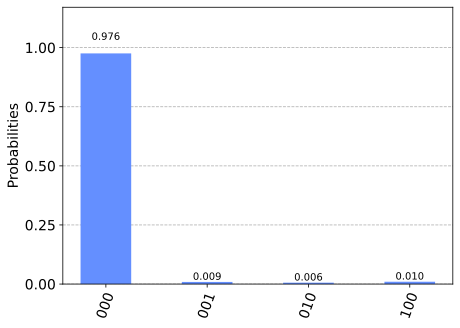

In [52]:
qc0 = QuantumCircuit(3) # initialize circuit with three qubits in the 0 state
qc0.measure_all() # measure the qubits

# run the circuit with th noise model and extract the counts
qobj = assemble(qc0)
counts = qasm_sim.run(qobj, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

Here we see that almost all results still come out `'000'`, as they would if there was no noise. Of the remaining possibilities, those with a majority of `0`s are most likely. In total, much less than 10 samples come out with a majority of `1`s. When using this circuit to encode a `0`, this means that $P<1\%$

Now let's try the same for storing a `1` using three qubits in state $\left|1\right\rangle$.

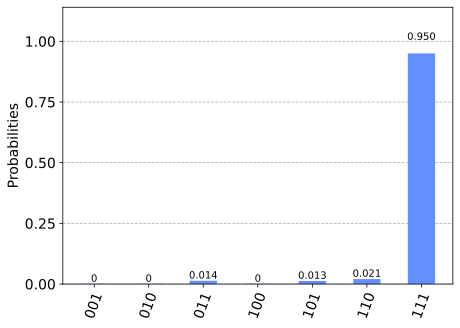

In [53]:
qc1 = QuantumCircuit(3) # initialize circuit with three qubits in the 0 state
qc1.x([0,1,2]) # flip each 0 to 1

qc1.measure_all() # measure the qubits

# run the circuit with th noise model and extract the counts
qobj = assemble(qc1)
counts = qasm_sim.run(qobj, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

The number of samples that come out with a majority in the wrong state (`0` in this case) is again much less than 10, so $P<1\%$. Whether we store a `0` or a `1`, we can retrieve the information with a smaller probability of error than either of our sources of noise.

This was possible because the noise we considered was relatively weak. As we increase $p_{meas}$ and $p_{gate}$, the higher the probability $P$ will be. The extreme case of this is for either of them to have a $50/50$ chance of applying the bit flip error, `x`. For example, let's run the same circuit as before but with $p_{meas}=0.5$ and $p_{gate}=0$.

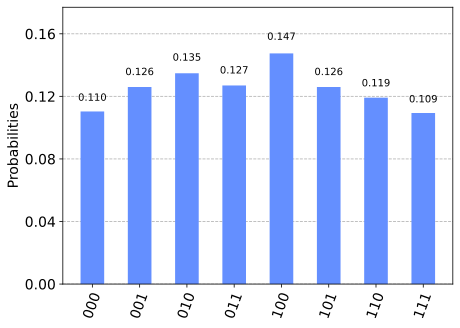

In [54]:
noise_model = get_noise(0.5,0.0)
qobj = assemble(qc1)
counts = qasm_sim.run(qobj, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

With this noise, all outcomes occur with equal probability, with differences in results being due only to statistical noise. No trace of the encoded state remains. This is an important point to consider for error correction: sometimes the noise is too strong to be corrected. The optimal approach is to combine a good way of encoding the information you require, with hardware whose noise is not too strong.

### Storing qubits

So far, we have considered cases where there is no delay between encoding and decoding. For qubits, this means that there is no significant amount of time that passes between initializing the circuit, and making the final measurements.

However, there are many cases for which there will be a significant delay. As an obvious example, one may wish to encode a quantum state and store it for a long time, like a quantum hard drive. A less obvious but much more important example is performing fault-tolerant quantum computation itself. For this, we need to store quantum states and preserve their integrity during the computation. This must also be done in a way that allows us to manipulate the stored information in any way we need, and which corrects any errors we may introduce when performing the manipulations.

In all cases, we need account for the fact that errors do not only occur when something happens (like a gate or measurement), they also occur when the qubits are idle. Such noise is due to the fact that the qubits interact with each other and their environment. The longer we leave our qubits idle for, the greater the effects of this noise becomes. If we leave them for long enough, we'll encounter a situation like the $p_{meas}=0.5$ case above, where the noise is too strong for errors to be reliably corrected.

The solution is to keep measuring throughout. No qubit is left idle for too long. Instead, information is constantly being extracted from the system to keep track of the errors that have occurred.

For the case of classical information, where we simply wish to store a `0` or `1`, this can be done by just constantly measuring the value of each qubit. By keeping track of when the values change due to noise, we can easily deduce a history of when errors occurred. 

For quantum information, however, it is not so easy. For example, consider the case that we wish to encode the logical state $\left|+\right\rangle$. Our encoding is such that



$$\left|0\right\rangle \rightarrow \left|000\right\rangle,~~~ \left|1\right\rangle \rightarrow \left|111\right\rangle.$$



To encode the logical $\left|+\right\rangle$ state we therefore need



$$\left|+\right\rangle=\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\rightarrow \frac{1}{\sqrt{2}}\left(\left|000\right\rangle+\left|111\right\rangle\right).$$



With the repetition encoding that we are using, a z measurement (which distinguishes between the $\left|0\right\rangle$ and $\left|1\right\rangle$ states) of the logical qubit is done using a z measurement of each physical qubit. The final result for the logical measurement is decoded from the physical qubit measurement results by simply looking which output is in the majority.

As mentioned earlier, we can keep track of errors on logical qubits that are stored for a long time by constantly performing z measurements of the physical qubits. However, note that this effectively corresponds to constantly performing z measurements of the physical qubits. This is fine if we are simply storing a `0` or `1`, but it has undesired effects if we are storing a superposition. Specifically: the first time we do such a check for errors, we will collapse the superposition.

This is not ideal. If we wanted to do some computation on our logical qubit, or if we wish to perform a basis change before final measurement, we need to preserve the superposition. Destroying it is an error. But this is not an error caused by imperfections in our devices. It is an error that we have introduced as part of our attempts to correct errors. And since we cannot hope to recreate any arbitrary superposition stored in our quantum computer, it is an error that cannot be corrected.

For this reason, we must find another way of keeping track of the errors that occur when our logical qubit is stored for long times. This should give us the information we need to detect and correct errors, and to decode the final measurement result with high probability. However, it should not cause uncorrectable errors to occur during the process by collapsing superpositions that we need to preserve.

The way to do this is with the following circuit element.

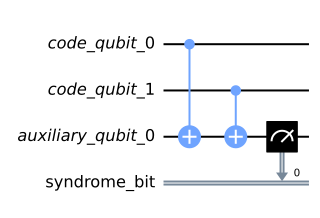

In [55]:
cq = QuantumRegister(2, 'code_qubit')
lq = QuantumRegister(1, 'auxiliary_qubit')
sb = ClassicalRegister(1, 'syndrome_bit')
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw()

Here we have three physical qubits. Two are called 'code qubits', and the other is called an 'auxiliary qubit'. One bit of output is extracted, called the syndrome bit. The auxiliary qubit is always initialized in state $\left|0\right\rangle$. The code qubits, however, can be initialized in different states. To see what affect different inputs have on the output, we can create a circuit `qc_init` that prepares the code qubits in some state, and then run the circuit `qc_init+qc`.

First, the trivial case: `qc_init` does nothing, and so the code qubits are initially $\left|00\right\rangle$.

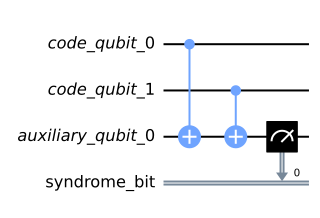

In [56]:
qc_init = QuantumCircuit(cq)
qc.compose(qc_init).draw()

In [58]:
qobj = assemble(qc.compose(qc_init))
counts = qasm_sim.run(qobj).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


The outcome, in all cases, is `0`.

Now let's try an initial state of $\left|11\right\rangle$.

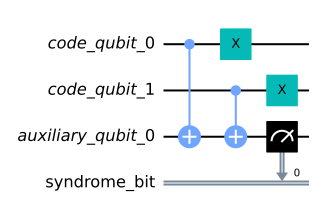

In [57]:
qc_init = QuantumCircuit(cq)
qc_init.x(cq)
qc.compose(qc_init).draw()

In [59]:
qobj = assemble(qc.compose(qc_init))
counts = qasm_sim.run(qobj).result().get_counts()
print('Results:', counts)

Results: {'0': 1024}


The outcome in this case is also always `0`. Given the linearity of quantum mechanics, we can expect the same to be true also for any superposition of $\left|00\right\rangle$ and $\left|11\right\rangle$, such as the example below.

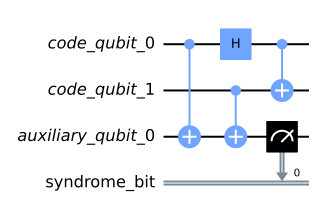

In [60]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0], cq[1])
qc.compose(qc_init).draw()

In [61]:
qobj = assemble(qc.compose(qc_init))
counts = qasm_sim.run(qobj).result().get_counts()
print('Results:',counts)

Results: {'0': 1024}


The opposite outcome will be found for an initial state of $\left|01\right\rangle$, $\left|10\right\rangle$ or any superposition thereof.

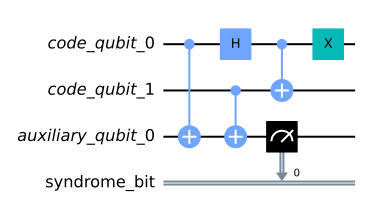

In [62]:
qc_init = QuantumCircuit(cq)
qc_init.h(cq[0])
qc_init.cx(cq[0], cq[1])
qc_init.x(cq[0])
qc.compose(qc_init).draw()

In [65]:
qobj = assemble(qc_init+qc)
counts = qasm_sim.run(qobj).result().get_counts()
print('Results:',counts)

Results: {'1': 1024}


In such cases the output is always `'1'`.

This measurement is therefore telling us about a collective property of multiple qubits. Specifically, it looks at the two code qubits and determines whether their state is the same or different in the z basis. For basis states that are the same in the z basis, like $\left|00\right\rangle$ and $\left|11\right\rangle$, the measurement simply returns `0`. It also does so for any superposition of these. Since it does not distinguish between these states in any way, it also does not collapse such a superposition.

Similarly, For basis states that are different in the z basis it returns a `1`. This occurs for $\left|01\right\rangle$, $\left|10\right\rangle$ or any superposition thereof.

Now suppose we apply such a 'syndrome measurement' on all pairs of physical qubits in our repetition code. If their state is described by a repeated $\left|0\right\rangle$, a repeated $\left|1\right\rangle$, or any superposition thereof, all the syndrome measurements will return `0`. Given this result, we will know that our states are indeed encoded in the repeated states that we want them to be, and can deduce that no errors have occurred. If some syndrome measurements return `1`, however, it is a signature of an error. We can therefore use these measurement results to determine how to decode the result.

### Quantum repetition code

We now know enough to understand exactly how the quantum version of the repetition code is implemented

We can use it in Qiskit by importing the required tools from Ignis.

In [66]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

We are free to choose how many physical qubits we want the logical qubit to be encoded in. We can also choose how many times the syndrome measurements will be applied while we store our logical qubit, before the final readout measurement. Let us start with the smallest non-trivial case: three repetitions and one syndrome measurement round. The circuits for the repetition code can then be created automatically from using the `RepetitionCode` object from Qiskit-Ignis.

In [67]:
n = 3
T = 1
code = RepetitionCode(n, T)

With this we can inspect various properties of the code, such as the names of the qubit registers used for the code and auxiliary qubits.

The `RepetitionCode` contains two quantum circuits that implement the code: One for each of the two possible logical bit values. Here are those for logical `0` and `1`, respectively.

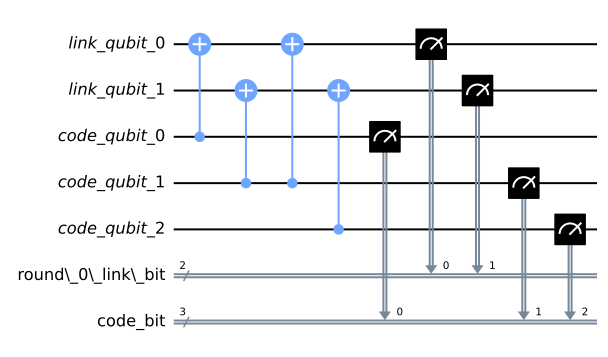

In [31]:
code.circuit['0'].draw()

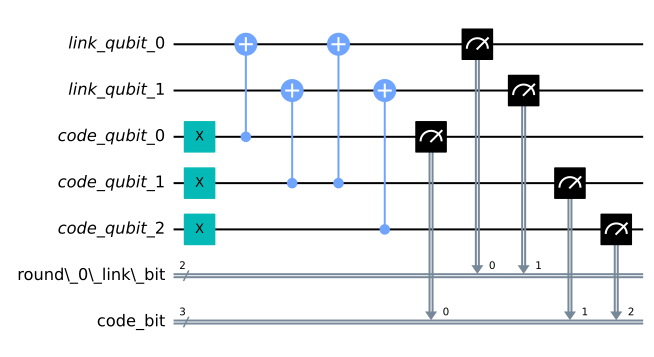

In [32]:
code.circuit['1'].draw()

In these circuits, we have two types of physical qubits. There are the 'code qubits', which are the three physical qubits across which the logical state is encoded. There are also the 'link qubits', which serve as the auxiliary qubits for the syndrome measurements.

Our single round of syndrome measurements in these circuits consist of just two syndrome measurements. One compares code qubits 0 and 1, and the other compares code qubits 1 and 2. One might expect that a further measurement, comparing code qubits 0 and 2, should be required to create a full set. However, these two are sufficient. This is because of the information on whether 0 and 2 have the same z basis state can be inferred from the same information about 0 and 1 with that for 1 and 2. Indeed, for $n$ qubits, we can get the required information from just $n-1$ syndrome measurements of neighbouring pairs of qubits.

Running these circuits on a simulator without any noise leads to very simple results.

In [68]:
def get_raw_results(code,noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        qobj = assemble(circuits[log])
        job = qasm_sim.run(qobj, noise_model=noise_model)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log, ':', raw_results[log], '\n')

Logical 0 : {'000 00': 1024} 

Logical 1 : {'111 00': 1024} 



Here we see that the output comes in two parts. The part on the right holds the outcomes of the two syndrome measurements. That on the left holds the outcomes of the three final measurements of the code qubits.

For more measurement rounds, $T=4$ for example, we would have the results of more syndrome measurements on the right.

In [69]:
code = RepetitionCode(n,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'000 00 00 00 00': 1024} 

Logical 1 : {'111 00 00 00 00': 1024} 



For more repetitions, $n=5$ for example, each set of measurements would be larger. The final measurement on the left would be of $n$ qubits. The $T$ syndrome measurements would each be of the $n-1$ possible neighbouring pairs.

In [70]:
code = RepetitionCode(5,4)

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'00000 0000 0000 0000 0000': 1024} 

Logical 1 : {'11111 0000 0000 0000 0000': 1024} 



### Lookup table decoding

Now let's return to the $n=3$, $T=1$ example and look at a case with some noise.

In [71]:
code = RepetitionCode(3,1)

noise_model = get_noise(0.05,0.05)

raw_results = get_raw_results(code,noise_model)
for log in raw_results:
    print('Logical', log,':', raw_results[log],'\n')

Logical 0 : {'110 10': 1, '110 01': 1, '110 00': 4, '100 11': 1, '010 00': 42, '011 01': 1, '000 01': 53, '001 10': 5, '100 00': 44, '000 10': 75, '101 00': 5, '100 10': 6, '101 10': 2, '010 11': 1, '000 00': 690, '001 00': 44, '000 11': 10, '011 00': 3, '100 01': 7, '010 10': 6, '001 01': 5, '010 01': 18} 

Logical 1 : {'011 11': 3, '010 11': 2, '010 10': 1, '100 01': 3, '001 01': 1, '010 01': 1, '011 01': 3, '110 10': 5, '110 11': 4, '110 01': 18, '011 10': 24, '111 10': 70, '111 00': 619, '101 00': 48, '111 01': 62, '100 00': 3, '101 01': 19, '011 00': 49, '101 11': 20, '110 00': 48, '100 11': 1, '001 10': 1, '001 00': 4, '010 00': 4, '101 10': 6, '111 11': 5} 



Here we have created `raw_results`, a dictionary that holds both the results for a circuit encoding a logical `0` and `1` encoded for a logical `1`.

Our task when confronted with any of the possible outcomes we see here is to determine what the outcome should have been, if there was no noise. For an outcome of `'000 00'` or `'111 00'`, the answer is obvious. These are the results we just saw for a logical `0` and logical `1`, respectively, when no errors occur. The former is the most common outcome for the logical `0` even with noise, and the latter is the most common for the logical `1`. We will therefore conclude that the outcome was indeed that for logical `0` whenever we encounter `'000 00'`, and the same for logical `1` when we encounter `'111 00'`.

Though this tactic is optimal, it can nevertheless fail. Note that `'111 00'` typically occurs in a handful of cases for an encoded `0`, and `'000 00'` similarly occurs for an encoded `1`. In this case, through no fault of our own, we will incorrectly decode the output. In these cases, a large number of errors conspired to make it look like we had a noiseless case of the opposite logical value, and so correction becomes impossible.

We can employ a similar tactic to decode all other outcomes. The outcome `'001 00'`, for example, occurs far more for a logical `0` than a logical `1`. This is because it could be caused by just a single measurement error in the former case (which incorrectly reports a single `0` to be `1`), but would require at least two errors in the latter. So whenever we see `'001 00'`, we can decode it as a logical `0`.

Applying this tactic over all the strings is a form of so-called 'lookup table decoding'. This is where every possible outcome is analyzed, and the most likely value to decode it as is determined. For many qubits, this quickly becomes intractable, as the number of possible outcomes becomes so large. In these cases, more algorithmic decoders are needed. However, lookup table decoding works well for testing out small codes.

We can use tools in Qiskit to implement lookup table decoding for any code. For this we need two sets of results. One is the set of results that we actually want to decode, and for which we want to calculate the probability of incorrect decoding, $P$. We will use the `raw_results` we already have for this.

The other set of results is one to be used as the lookup table. This will need to be run for a large number of samples, to ensure that it gets good statistics for each possible outcome. We'll use `shots=10000`.


In [72]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    qobj = assemble(circuits[log], shots=10000)
    job = qasm_sim.run(qobj, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

With this data, which we call `table_results`, we can now use the `lookuptable_decoding` function from Qiskit. This takes each outcome from `raw_results` and decodes it with the information in `table_results`. Then it checks if the decoding was correct, and uses this information to calculate $P$.

In [73]:
P = lookuptable_decoding(raw_results,table_results)
print('P =',P)

P = {'0': 0.0218, '1': 0.026}


Here we see that the values for $P$ are lower than those for $p_{meas}$ and $p_{gate}$, so we get an improvement in the reliability for storing the bit value. Note also that the value of $P$ for an encoded `1` is higher than that for `0`. This is because the encoding of `1` requires the application of `x` gates, which are an additional source of noise.

### Graph theoretic decoding

The decoding considered above produces the best possible results, and does so without needing to use any details of the code. However, it has a major drawback that counters these advantages: the lookup table grows exponentially large as code size increases. For this reason, decoding is typically done in a more algorithmic manner that takes into account the structure of the code and its resulting syndromes.

For the codes of `topological_codes` this structure is revealed using post-processing of the syndromes. Instead of using the form shown above, with the final measurement of the code qubits on the left and the outputs of the syndrome measurement rounds on the right, we use the `process_results` method of the code object to rewrite them in a different form.

For example, below is the processed form of a `raw_results` dictionary, in this case for $n=3$ and $T=2$. Only results with 50 or more samples are shown for clarity.

In [74]:
code = RepetitionCode(3,2)

raw_results = get_raw_results(code,noise_model)

results = code.process_results( raw_results )

for log in ['0','1']:
    print('\nLogical ' + log + ':')
    print('raw results       ', {string:raw_results[log][string] for string in raw_results[log] if raw_results[log][string]>=50 })
    print('processed results ', {string:results[log][string] for string in results[log] if results[log][string]>=50 })


Logical 0:
raw results        {'000 00 01': 57, '000 00 00': 457, '000 10 00': 55, '001 00 00': 56}
processed results  {'0 0  01 01 00': 57, '0 0  00 00 00': 457, '0 0  00 10 10': 55, '0 1  00 00 01': 56}

Logical 1:
raw results        {'111 00 01': 54, '111 00 00': 465}
processed results  {'1 1  01 01 00': 54, '1 1  00 00 00': 465}


Here we can see that `'000 00 00'` has been transformed to `'0 0  00 00 00'`, and `'111 00 00'` to `'1 1  00 00 00'`, and so on.

In these new strings, the `0 0` to the far left for the logical `0` results and the `1 1` to the far left of the logical `1` results are the logical readout. Any code qubit could be used for this readout, since they should (without errors) all be equal. It would therefore be possible in principle to just have a single `0` or `1` at this position. We could also do as in the original form of the result and have $n$, one for each qubit. Instead we use two, from the two qubits at either end of the line. The reason for this will be shown later. In the absence of errors, these two values will always be equal, since they represent the same encoded bit value.

After the logical values follow the $n-1$ results of the syndrome measurements for the first round. Note that the logical values in raw results follow the results of the syndrome measurements from the $T$-th round to the $T-1$-th round. A `0` implies that the corresponding pair of qubits have the same value, and `1` implies they are different from each other. There are $n-1$ results because the line of $n$ code qubits has $n-1$ possible neighboring pairs. In the absence of errors, they will all be `0`. This is exactly the same as the first such set of syndrome results from the original form of the result.

The next block is the next round of syndrome results. However, rather than presenting these results directly, it instead gives us the syndrome change between the first and second rounds. It is therefore the bitwise `OR` of the syndrome measurement results from the second round with those from the first. In the absence of errors, they will all be `0`.

Any subsequent blocks follow the same formula, though the last of all requires some comment. This is not measured using the standard method (with a link qubit). Instead it is calculated from the final readout measurement of all code qubits. Again it is presented as a syndrome change, and will be all `0` in the absence of errors. This is the $T+1$-th block of syndrome measurements since, as it is not done in the same way as the others, it is not counted among the $T$ syndrome measurement rounds.

The following examples further illustrate this convention.

**Example 1:** `0 0  0110 0000 0000` represents a $n=5$, $T=2$ repetition code with encoded `0`. The syndrome shows that (most likely) the middle code qubit was flipped by an error before the first measurement round. This causes it to disagree with both neighboring code qubits for the rest of the circuit. This is shown by the syndrome in the first round, but the blocks for subsequent rounds do not report it as it no longer represents a change. Other sets of errors could also have caused this syndrome, but they would need to be more complex and so presumably less likely.

**Example 2:** `0 0  0010 0010 0000` represents a $n=5$, $T=2$ repetition code with encoded `0`. Here one of the syndrome measurements reported a difference between two code qubits in the first round, leading to a `1`. The next round did not see the same effect, and so resulted in a `0`. However, since this disagreed with the previous result for the same syndrome measurement, and since we track syndrome changes, this change results in another `1`. Subsequent rounds also do not detect anything, but this no longer represents a change and hence results in a `0` in the same position. Most likely the measurement result leading to the first `1` was an error.

**Example 3:** `0 1  0000 0001 0000` represents a $n=5$, $T=2$ repetition code with encoded `0`. A code qubit on the end of the line is flipped before the second round of syndrome measurements. This is detected by only a single syndrome measurement, because it is on the end of the line. For the same reason, it also disturbs one of the logical readouts.

Note that in all these examples, a single error causes exactly two characters in the string to change from the value they would have with no errors. This is the defining feature of the convention used to represent stabilizers in `topological_codes`. It is used to define the graph on which the decoding problem is defined.  

Specifically, the graph is constructed by first taking the circuit encoding logical `0`, for which all bit values in the output string should be `0`. Many copies of this are then created and run on a simulator, with a different single Pauli operator inserted into each. This is done for each of the three types of Pauli operators on each of the qubits and at every circuit depth. The output from each of these circuits can be used to determine the effects of each possible single error. Since the circuit contains only Clifford operations, the simulation can be performed efficiently.

In each case, the error will change exactly two of the characters (unless it has no effect). A graph is then constructed for which each bit of the output string corresponds to a node, and the pairs of bits affected by the same error correspond to an edge.

The process of decoding a particular output string typically requires the algorithm to deduce which set of errors occurred, given the syndrome found in the output string. This can be done by constructing a second graph, containing only nodes that correspond to non-trivial syndrome bits in the output. An edge is then placed between each pair of nodes, with a corresponding weight equal to the length of the minimal path between those nodes in the original graph. A set of errors consistent with the syndrome then corresponds to finding a perfect matching of this graph. To deduce the most likely set of errors to have occurred, a good tactic would be to find one with the least possible number of errors that is consistent with the observed syndrome. This corresponds to a minimum weight perfect matching of the graph.

Using minimal weight perfect matching is a standard decoding technique for the repetition code and surface code, and is implement in Qiskit Ignis. It can also be used in other cases, such as Color codes, but it does not find the best approximation of the most likely set of errors for every code and noise model. For that reason, other decoding techniques based on the same graph can be used. The `GraphDecoder` of Qiskit Ignis calculates these graphs for a given code, and will provide a range of methods to analyze it. At time of writing, only minimum weight perfect matching is implemented.

Note that, for codes such as the surface code, it is not strictly true than each single error will change the value of only two bits in the output string. A $\sigma^y$ error, for example would flip a pair of values corresponding to two different types of stabilizer, which are typically decoded independently. Output for these codes will therefore be presented in a way that acknowledges this, and analysis of such syndromes will correspondingly create multiple independent graphs to represent the different syndrome types.

## Running a repetition code benchmarking procedure

We will now run examples of repetition codes on real devices, and use the results as a benchmark. First, we will briefly summarize the process. This applies to this example of the repetition code, but also for other benchmarking procedures in `topological_codes`, and indeed for Qiskit Ignis in general. In each case, the following three-step process is used.

1. A task is defined. Qiskit Ignis determines the set of circuits that must be run and creates them.
2. The circuits are run. This is typically done using Qiskit. However, in principle any service or experimental equipment could be interfaced.
3. Qiskit Ignis is used to process the results from the circuits, to create the output required for the given task.

For `topological_codes`, step 1 requires the type and size of quantum error correction code to be chosen. Each type of code has a dedicated Python class. A corresponding object is initialized by providing the parameters required, such as `n` and `T` for a `RepetitionCode` object. The resulting object contains the circuits corresponding to the given code encoding simple logical qubit states (such as $\left|0\right\rangle$ and $\left|1\right\rangle$). Step 2 consists in running the procedure of error detection for a specified number of rounds on these circuits, before final readout in a straightforward logical basis (typically a standard $\left|0\right\rangle$/$\left|1\right\rangle$ measurement).

For `topological_codes`, the main processing of step 3 is the decoding, which aims to mitigate for any errors in the final readout by using the information obtained from error detection. The optimal algorithm for decoding typically varies between codes. However, codes with similar structure often make use of similar methods.

The aim of `topological_codes` is to provide a variety of decoding methods, implemented such that all the decoders can be used on all of the codes. This is done by restricting to codes for which decoding can be described as a graph-theoretic minimization problem. This classic example of such codes are the toric and surface codes. The property is also shared by 2D color codes and matching codes. All of these are prominent examples of so-called topological quantum error correcting codes, which led to the name of the subpackage. However, note that not all topological codes are compatible with such a decoder. Also, some non-topological codes will be compatible, such as the repetition code.

The decoding is done by the `GraphDecoder` class. A corresponding object is initialized by providing the code object for which the decoding will be performed. This is then used to determine the graph on which the decoding problem will be defined. The results can then be processed using the various methods of the decoder object.

In the following we will see the above ideas put into practice for the repetition code. In doing this we will employ two Boolean variables, `step_2` and `step_3`. The variable `step_2` is used to show which parts of the program need to be run when taking data from a device, and `step_3` is used to show the parts which process the resulting data.

Both are set to false by default, to ensure that all the program snippets below can be run using only previously collected and processed data. However, to obtain new data one only needs to use `step_2 = True`, and perform decoding on any data one only needs to use `step_3 = True`.

In [75]:
step_2 = False
step_3 = False

To benchmark a real device we need the tools required to access that device over the cloud, and compile circuits suitable to run on it. These are imported as follows.

In [76]:
from qiskit import IBMQ
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.tools import job_monitor

We can now create the backend object, which is used to run the circuits. This is done by supplying the string used to specify the device. Here `'ibmq_16_melbourne'` is used, which has 15 active qubits at time of writing. We will also consider the 53 qubit *Rochester* device, which is specified with `'ibmq_rochester'`.

In [30]:
device_name = 'ibmq_16_melbourne'

if step_2 or step_3:
    
    IBMQ.load_account()
    
    for provider in IBMQ.providers():
        for potential_backend in provider.backends():
            if potential_backend.name()==device_name:
                backend = potential_backend

    coupling_map = backend.configuration().coupling_map

When running a circuit on a real device, a transpilation process is first implemented. This changes the gates of the circuit into the native gate set implement by the device. In some cases these changes are fairly trivial, such as expressing each Hadamard as a single qubit rotation by the corresponding Euler angles. However, the changes can be more major if the circuit does not respect the connectivity of the device. For example, suppose the circuit requires a controlled-NOT that is not directly implemented by the device. The effect must be then be reproduced with techniques such as using additional controlled-NOT gates to move the qubit states around. As well as introducing additional noise, this also delocalizes any noise already present. A single qubit error in the original circuit could become a multiqubit monstrosity under the action of the additional transpilation. Such non-trivial transpilation must therefore be prevented when running quantum error correction circuits.

Tests of the repetition code require qubits to be effectively ordered along a line. The only controlled-NOT gates required are between neighbours along that line. Our first job is therefore to study the coupling map of the device, and find a line.

![Fig. 1. The coupling map of the IBM Q Melbourne device.](images/melbourne.png)

For Melbourne it is possible to find a line that covers all 15 qubits. The choice one specified in the list `line` below is designed to avoid the most error prone `cx` gates. For the 53 qubit *Rochester* device, there is no single line that covers all 53 qubits. Instead we can use the following choice, which covers 43.

In [31]:
if device_name=='ibmq_16_melbourne':
    line = [13,14,0,1,2,12,11,3,4,10,9,5,6,8,7]
elif device_name=='ibmq_rochester':
    line = [10,11,17,23,22,21,20,19,16,7,8,9,5]#,0,1,2,3,4,6,13,14,15,18,27,26,25,29,36,37,38,41,50,49,48,47,46,45,44,43,42,39,30,31]

Now we know how many qubits we have access to, we can create the repetition code objects for each code that we will run. Note that a code with `n` repetitions uses $n$ code qubits and $n-1$ link qubits, and so $2n-1$ in all.

In [32]:
n_min = 3
n_max = int((len(line)+1)/2)

code = {}

for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

Before running the circuits from these codes, we need to ensure that the transpiler knows which physical qubits on the device it should use. This means using the qubit of `line[0]` to serve as the first code qubit, that of `line[1]` to be the first link qubit, and so on. This is done by the following function, which takes a repetition code object and a `line`, and creates a Python dictionary to specify which qubit of the code corresponds to which element of the line.

In [33]:
def get_initial_layout(code,line,n):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

Now we can transpile the circuits, to create the circuits that will actually be run by the device. A check is also made to ensure that the transpilation indeed has not introduced non-trivial effects by increasing the number of qubits. Furthermore, the compiled circuits are collected into a single list, to allow them all to be submitted at once in the same batch job.

In [34]:
if step_2:
    circuits = []
    for n in range(n_min,n_max+1):
        initial_layout = get_initial_layout(code[n],line,n)
        for log in ['0','1']:
            circuits.append( transpile(code[n].circuit[log], backend=backend, initial_layout=initial_layout) )
            num_cx = dict(circuits[-1].count_ops())['cx']
            assert num_cx==2*(n-1), str(num_cx) + ' instead of ' + str(2*(n-1)) + ' cx gates for n = ' + str(n)

We are now ready to run the job. As with the simulated jobs considered already, the results from this are extracted into a dictionary `raw_results`. However, in this case it is extended to hold the results from different code sizes. This means that `raw_results[n]` in the following is equivalent to one of the `raw_results` dictionaries used earlier, for a given `n`.

In [35]:
if step_2:
    # run all the circuits
    job = backend.run(circuits, shots=8192)
    job_monitor(job)

    # organize the results of the run
    raw_results = {}
    j = 0
    for d in range(n_min,n_max+1):
        raw_results[d] = {}
        for log in ['0','1']:
            raw_results[d][log] = job.result().get_counts(j)
            j += 1

It can be convenient to save the data to file, so that the processing of step 3 can be done or repeated at a later time.

In [36]:
if step_2: # save results
    with open('results/raw_results_'+device_name+'.txt', 'w') as file:
        file.write(str(raw_results))
elif step_3: # read results
    with open('results/raw_results_'+device_name+'.txt', 'r') as file:
        raw_results = eval(file.read())

As we saw previously, the process of decoding first needs the results to be rewritten in order for the syndrome to be expressed in the correct form. As such, the `process_results` method of each the repetition code object `code[n]` is used to create a results dictionary `results[n]` from each `raw_results[n]`.

In [37]:
if step_3:
    results = {}
    for n in range(n_min,n_max+1):
        results[n] = code[n].process_results( raw_results[n] )

The decoding also needs us to set up the `GraphDecoder` object for each code. The initialization of these involves the construction of the graph corresponding to the syndrome, as described in the last section.

In [38]:
if step_3:
    dec = {}
    for n in range(n_min,n_max+1):
        dec[n] = GraphDecoder(code[n])

Finally, the decoder object can be used to process the results. Here the default algorithm, minimum weight perfect matching, is used. The end result is a calculation of the logical error probability. When running step 3, the following snippet also saves the logical error probabilities. Otherwise, it reads in previously saved probabilities.

In [39]:
if step_3:
    logical_prob_match = {}
    for n in range(n_min,n_max+1):
        logical_prob_match[n] = dec[n].get_logical_prob(results[n])
        
    with open('results/logical_prob_match_'+device_name+'.txt', 'w') as file:
        file.write(str(logical_prob_match))
        
else:
    with open('results/logical_prob_match_'+device_name+'.txt', 'r') as file:
        logical_prob_match = eval(file.read())

The resulting logical error probabilities are displayed in the following graph, which uses a log scale used on the y axis. We would expect that the logical error probability decays exponentially with increasing $n$. If this is the case, it is a confirmation that the device is compatible with this basis test of quantum error correction. If not, it implies that the qubits and gates are not sufficiently reliable.

Fortunately, the results from IBM Q prototype devices typically do show the expected exponential decay. For the results below, we can see that small codes do represent an exception to this rule. Other deviations can also be expected, such as when an increase in the size of the code includes a group of qubits with either exceptionally low or high noise.

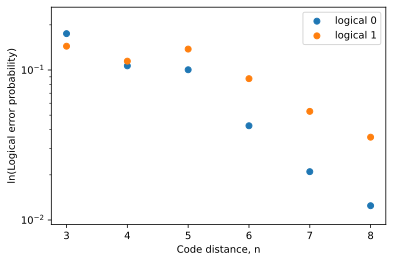

In [40]:
import matplotlib.pyplot as plt
import numpy as np

x_axis = range(n_min,n_max+1)
P = { log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1'] }

ax = plt.gca()
plt.xlabel('Code distance, n')
plt.ylabel('ln(Logical error probability)')
ax.scatter( x_axis, P['0'], label="logical 0")
ax.scatter( x_axis, P['1'], label="logical 1")
ax.set_yscale('log')
ax.set_ylim(ymax=1.5*max(P['0']+P['1']),ymin=0.75*min(P['0']+P['1']))
plt.legend()
plt.show()

Another insight we can gain is to use the results to determine how likely certain error processes are to occur.

To do this we use the fact that each edge in the syndrome graph represents a particular form of error, occurring on a particular qubit at a particular point within the circuit. This is the unique single error that causes the syndrome values corresponding to both of the adjacent nodes to change. Using the results to estimate the probability of such a syndrome therefore allows us to estimate the probability of such an error event. Specifically, to first order it is clear that

$$
\frac{p}{1-p} \approx \frac{C_{11}}{C_{00}}
$$

Here $p$ is the probability of the error corresponding to a particular edge, $C_{11}$ is the number of counts in the `results[n]['0']` corresponding to the syndrome value of both adjacent nodes being `1`, and $C_{00}$ is the same for them both being `0`.

The decoder object has a method `weight_syndrome_graph` which determines these ratios, and assigns each edge the weight $-\ln(p/(1-p))$. By employing this method and inspecting the weights, we can easily retrieve these probabilities.

In [41]:
if step_3:

    dec[n_max].weight_syndrome_graph(results=results[n_max])

    probs = []
    for edge in dec[n_max].S.edges:
        ratio = np.exp(-dec[n_max].S.get_edge_data(edge[0],edge[1])['distance'])
        probs.append( ratio/(1+ratio) )
        
    with open('results/probs_'+device_name+'.txt', 'w') as file:
        file.write(str(probs))
        
else:
    
    with open('results/probs_'+device_name+'.txt', 'r') as file:
        probs = eval(file.read())

Rather than display the full list, we can obtain a summary via the mean, standard deviation, minimum, maximum and quartiles.

In [42]:
import pandas as pd
pd.Series(probs).describe()

count    29.000000
mean      0.183962
std       0.089693
min       0.032100
25%       0.120208
50%       0.154798
75%       0.258527
max       0.382057
dtype: float64

The benchmarking of the devices does not produce any set of error probabilities that is exactly equivalent. However, the probabilities for readout errors and controlled-NOT gate errors could serve as a good comparison. Specifically, we can use the `backend` object to obtain these values from the benchmarking.

In [43]:
if step_3:

    gate_probs = []
    for j,qubit in enumerate(line):
        
        gate_probs.append(backend.properties().readout_error(qubit) )
        
        cx1,cx2 = 0,0
        if j>0:
            gate_probs.append(backend.properties().gate_error('cx',[qubit,line[j-1]]) )
        if j<len(line)-1:
            gate_probs.append(backend.properties().gate_error('cx',[qubit,line[j+1]]) )
                
    with open('results/gate_probs_'+device_name+'.txt', 'w') as file:
        file.write(str(gate_probs))
        
else:
    
    with open('results/gate_probs_'+device_name+'.txt', 'r') as file:
        gate_probs = eval(file.read())
    
pd.Series(gate_probs).describe()

count    43.000000
mean      0.039642
std       0.022275
min       0.012790
25%       0.025390
50%       0.032965
75%       0.046332
max       0.116600
dtype: float64

In [77]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.0', 'qiskit-aer': '0.8.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.0', 'qiskit': '0.25.0'}